Frequency cluster analysis per conditions
Time range: stimulus onset to 450ms past onset

In [37]:
%reset

### 1e-6*

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mne import stats
from mne import create_info
from IPython.utils import io
import pickle
from os.path import exists
from auxiliary import AuxFuncs
import mne
import os
from os.path import exists

In [39]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"
trial_exclution_str = "_excOulierTrials-3.5"#"_excOulierTrials-2.5"

## Import epochs

In [40]:
import_path = f'{epochs_dir}\\{import_type}{trial_exclution_str}.pkl'
aux = AuxFuncs(import_path)

allEpochs_perCond = aux.allEpochs_condIdDict
allEvents_df = aux.allEvents_df
c = aux.config
times = c['times']
time0_i = c['time0_i']
ax_y = c['hz_y']

fig_output_dir = f"{c['outputs_dir_path']}/freq_clusterPerm"
if not os.path.exists(fig_output_dir):
    os.mkdir(fig_output_dir)

In [41]:
frq_filename = f'{epochs_dir}\\{import_type}{trial_exclution_str}_frq.pkl'

if exists(frq_filename):
    with open(frq_filename, 'rb') as config_dictionary_file:
        allEpochs_perCond_freq = pickle.load(config_dictionary_file)
        #print(allEpochs_perCond_freq)
else:
    allEpochs_perCond_freq = {}
    for key in allEpochs_perCond:
        allEpochs_perCond_freq[key] = np.zeros((len(c['electrodes']),len(ax_y),allEpochs_perCond[key].shape[2]))
        for el in range(len(c['electrodes'])):
            for tr in range(allEpochs_perCond[key].shape[2]):
                curr_trial_in_electr = allEpochs_perCond[key][el,time0_i:,tr]
                fft_abs = np.absolute(np.fft.rfft(curr_trial_in_electr))
                fft_norm = (fft_abs- np.min(fft_abs)) / (np.max(fft_abs) - np.min(fft_abs))
                allEpochs_perCond_freq[key][el,:,tr] = fft_norm
    with open(frq_filename, 'wb') as epochs_Wn_s_example_file:
        pickle.dump(allEpochs_perCond_freq, epochs_Wn_s_example_file)

## Clusters and evoked funcs

In [42]:
def getClustersPerConditions(dataset, contrastTypeName,contrasts,conditions,ax_y):
    cluster_subjs = [] # list (size subs) of list (size pairs) of len(ax_y) samps each
    for s,subject in enumerate(c['subs']):
        cluster_pair = []
        conditions['Subject'] = subject
        for pair in contrasts: # averaged across trials
            conditions[contrastTypeName] = pair[0]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEvents_df,dataset,ax_y)
            meanOverTrials_first = np.nanmean(evoked_perCond_andElectd,axis=0)

            conditions[contrastTypeName] = pair[1]
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(conditions,allEvents_df,dataset,ax_y)
            meanOverTrials_sec = np.nanmean(evoked_perCond_andElectd,axis=0)

            diff_sub_pair_mean = np.nanmean(meanOverTrials_first - meanOverTrials_sec, axis=0)
            if ~np.all(diff_sub_pair_mean==0) and ~np.isnan(diff_sub_pair_mean).any():
                cluster_pair.append(diff_sub_pair_mean)
        cluster_subjs.append(cluster_pair)

    """ Perform cluster permutation (paired t-test) """
    cluster_res={}
    for n, pair in enumerate(contrasts):
        curr_pair_res ={}
        curr_dif_arr = np.asarray(cluster_subjs)[:,n,:]
        curr_pair_res['T_obs'], curr_pair_res['clusters_equal'],curr_pair_res['cluster_equal_pv'],curr_pair_res['H0'] = stats.permutation_cluster_1samp_test(curr_dif_arr,n_permutations=1000, buffer_size=None)

        cluster_res[f"{pair[0]}_{pair[1]}"] = curr_pair_res

    return cluster_res

In [43]:


""" create a df with the clusters details"""
#bonferroni correction (0.05/6)=0.0083
def get_clusters_dfs(ax_y, contrasts, cluster_res,p_crit = 0.05):
    comparison = []
    p_values = []
    start = []
    end = []
    for s,pair in enumerate(contrasts):
        comparison_level = []
        start_level = []
        end_level = []

        contrast_str = f"{pair[0]}_{pair[1]}"
        curr_cluster_equal = cluster_res[contrast_str]['clusters_equal']
        curr_cluster_equal_pv = cluster_res[contrast_str]['cluster_equal_pv']
        cluster_res[contrast_str]['cl_'] = []

        if len(curr_cluster_equal)==0: continue
        for i_clu, clu_idx in enumerate(curr_cluster_equal):
            clu_idx = clu_idx[0]
            comparison_level.append(contrast_str)
            start_level.append(ax_y[clu_idx[0]])
            end_level.append(ax_y[clu_idx[-1]])
            if curr_cluster_equal_pv[i_clu] <= p_crit:
                cluster_res[contrast_str]['cl_'].append((ax_y[clu_idx[0]],ax_y[clu_idx[-1]]))
        comparison.append(comparison_level)
        start.append(start_level)
        end.append(end_level)
        p_values.append(list(curr_cluster_equal_pv))

    # Create dataframe
    if len(comparison)>0:
        comparison = np.concatenate(comparison)
        p_values = np.concatenate(p_values)
        start = np.concatenate(start)
        end = np.concatenate(end)
    d = {'Comparison': comparison,'p-value': p_values,'start (ms)': start,'end (ms)': end}
    clusters = pd.DataFrame(data=d)

    sig_clus = clusters.drop(clusters[clusters['p-value']>p_crit].index)
    return clusters, sig_clus

In [44]:
def get_contrasts_ax(ax, contrasts, contrastsColors,cluster_res):
    min_y = -0.02
    order_of_mag =0.02
    for s,contrast in enumerate(contrasts):
        contrast_str = f"{contrast[0]}_{contrast[1]}"
        curr_cl = cluster_res[contrast_str]['cl_']
        for i in range(len(curr_cl)):
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [min_y-(s*order_of_mag),min_y-(s*order_of_mag)],'-', color = contrastsColors[s][0], linewidth = 2)
            ax.plot([curr_cl[i][0],curr_cl[i][1]], [min_y-(s*order_of_mag),min_y-(s*order_of_mag)],'--', color = contrastsColors[s][1], linewidth = 2)

In [45]:
# def get_evokedPerCond_ax_mneFunc(ax1,df,condName : str, condVaribles, filterConds, graphColors):
#     evokeds = {}
#     for s,subject in enumerate(subs):
#         evokeds[s] = {}
#         filterConds['Subject'] = subject
#         for val in condVaribles:
#             filterConds[condName] = val
#             curr_subAndCond_electrOverTime = get_avgOverTrials(df, filterConds)
#             curr_subAndCond_electrOverTime /= 1e6
#             info=create_info(ch_names=ch_names,ch_types='eeg',sfreq=sfreq)
#             evokeds[s][val] = mne.EvokedArray(curr_subAndCond_electrOverTime,info,tmin=-0.1)
#
#     # Edit the data to mne plot format
#     evokeds_mnePlotFormat = {}
#     for val in condVaribles:
#         evokeds_mnePlotFormat[val] = []
#         for sub_i in range(len(subs)):
#             evokeds_mnePlotFormat[val].append(evokeds[sub_i][val])
#
#     plot_compare_evokeds(evokeds_mnePlotFormat,combine = 'mean',colors=graphColors,
#                          axes=ax1,show=False,truncate_xaxis=False, truncate_yaxis=False,
#                          show_sensors = False , legend='upper left')


def applyDesign(fig,ax,y_lims, x_lims,title=''):
    fig.patch.set_facecolor('#f5f1ecff')
    fig.edgecolor = '#f5f1ecff'
    ax.set_facecolor('silver')
    ax.set_title(title,fontsize = 18, fontweight = 'bold')
    ax.legend(loc = 'upper right',prop={'size': 10})
    ax.axvline(x=0,color='gray', linestyle='--',label ="_nolegend_")
    ax.axhline(y=0, color='gray', linestyle='-',label ="_nolegend_")
    ax.set_ylabel('magnitude', fontsize = 16, fontweight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Frequency (Hz)', fontsize = 16, fontweight = 'bold')
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)

def get_evokedPerCond_ax(dataset, ax1,condName : str, ax_y,condVaribles, filterConds, graphColors,graphTitles):
    all_evokeds = np.zeros((len(c['subs']),len(condVaribles) , len(ax_y)))
    for s,subject in enumerate(c['subs']):
        filterConds['Subject'] = subject
        for v,val in enumerate(condVaribles):
            filterConds[condName] = val
            conds_df, evoked_perCond_andElectd = aux.getEvokedPerCondAndElectd(filterConds,allEvents_df,dataset,ax_y)
            curr_subAndCond_electrOverTime = np.nanmean(evoked_perCond_andElectd,axis=0)
            all_evokeds[s,v,:] = np.nanmean(curr_subAndCond_electrOverTime,axis=0)

    mean_ = np.nanmean(all_evokeds,axis=0)
    std_ = np.nanstd(all_evokeds/np.sqrt(all_evokeds.shape[0]),axis=0)

    ax1.plot(ax_y,mean_.T)
    for v,val in enumerate(condVaribles):
        ax1.fill_between(ax_y,mean_[v]+std_[v] ,mean_[v]-std_[v], color=graphColors[v],alpha=0.1,label ="_nolegend_")
        ax1.plot(ax_y,mean_[v],label = graphTitles[v],color=graphColors[v])
    return ax1,np.min(mean_),np.max(mean_)

In [53]:
def run_cluster_permutation(dataset,ax_y,condVaribles_graphName,showClusterDfs=False):
    ### get df cluster info
    with io.capture_output() as captured: # suppress output
        cluster_res = getClustersPerConditions(dataset,contrastTypeName,contrasts,filters,ax_y)
        all_clust_df, sig_clust_df = get_clusters_dfs(ax_y,contrasts,cluster_res)
    if showClusterDfs:
        display(all_clust_df)
        display(sig_clust_df)
    ### plot clusters
    fig,ax1 = plt.subplots()
    ax1,min_y,max_y = get_evokedPerCond_ax(dataset,ax1, contrastTypeName,ax_y, contrast_seperateVal, filters, contrasts_sep_colors,condVaribles_graphName)
    #get_contrasts_ax(ax1, contrasts, contrastsColors,cluster_res)
    applyDesign(fig, ax1,[0,0.9],[0,50],f'{filters_string}')
    return ax1

# Resutls

In [48]:
contrasts = [['Wn','N2'],['Wn','N3'],['Wn','REM'],['N2','N3'],['N2','REM'],['REM','N3']]
contrastsColors = [['blue', 'orange'], ['blue', 'green'], ['blue', 'red'], ['orange', 'green'], ['orange', 'red'], ['red', 'green']]
contrastTypeName = 'Vigilance'
contrast_seperateVal = ['Wn','N2','N3','REM']
contrasts_sep_colors = c['colors_perVg_oneShade']

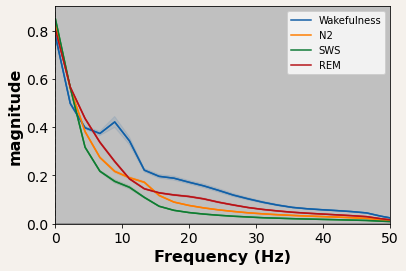

In [54]:
filters= {}
filters_string = f""
ax = run_cluster_permutation(allEpochs_perCond_freq,ax_y,c['titles_perVg'])
plt.savefig(f'{fig_output_dir}/freqCluster-allValidSubs_perVigi_5CentElect.png')
plt.show()

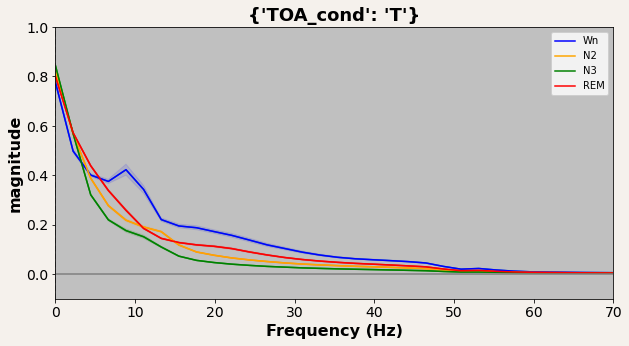

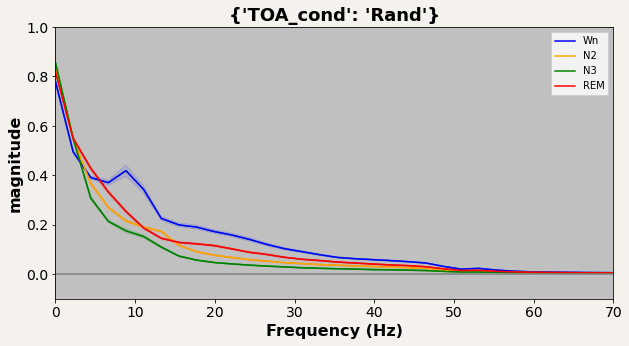

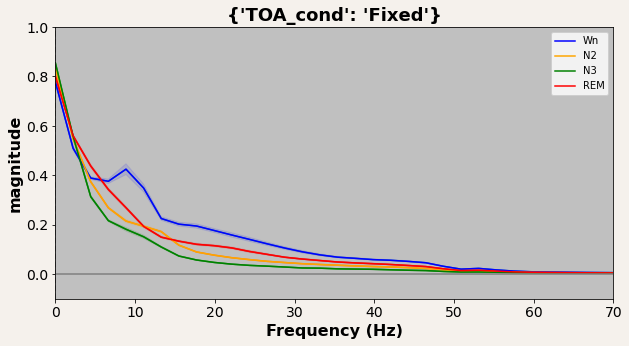

In [ ]:
for TOA_cond in ['T','Rand','Fixed']:
    filters= {'TOA_cond':TOA_cond}
    filters_string = f"{filters}"
    ax = run_cluster_permutation(allEpochs_perCond_freq,ax_y)

    plt.savefig(f'{fig_output_dir}/freqCluster-{TOA_cond}_allValidSubs_perVigi_5CentElect.png')
    plt.show()

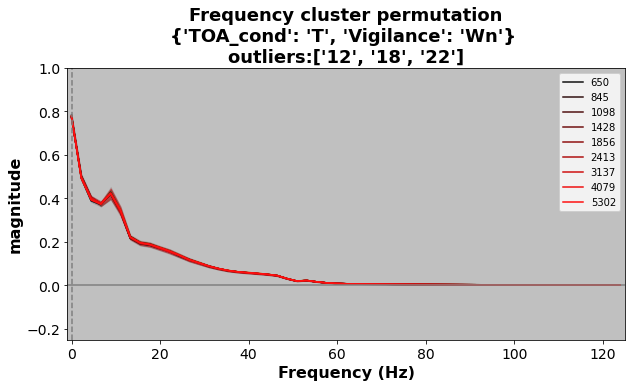

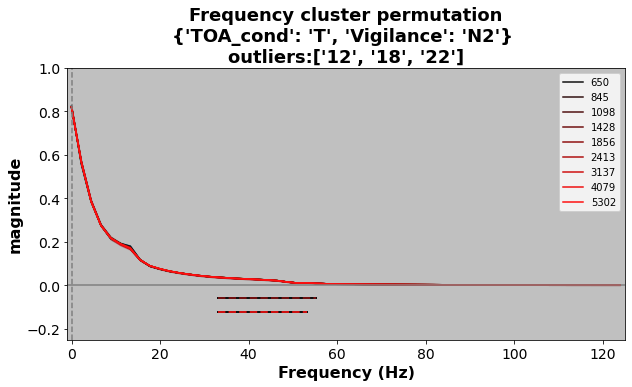

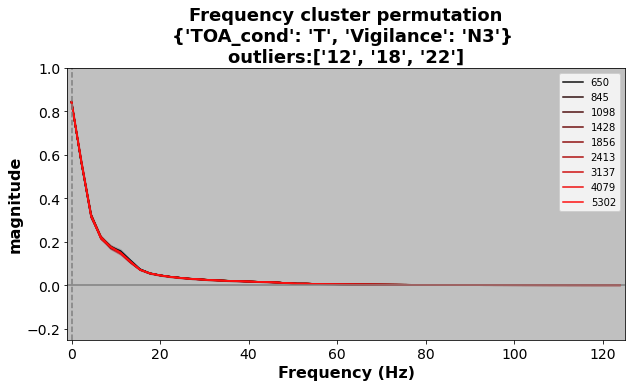

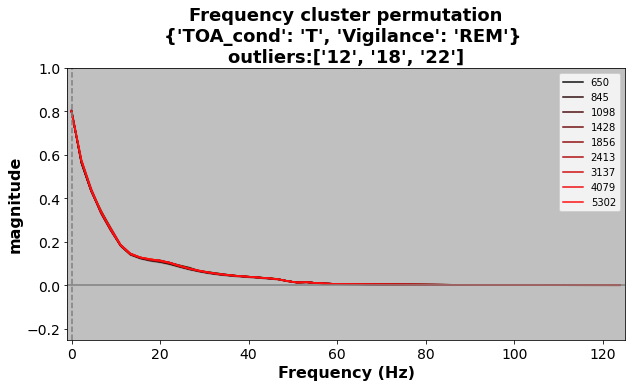

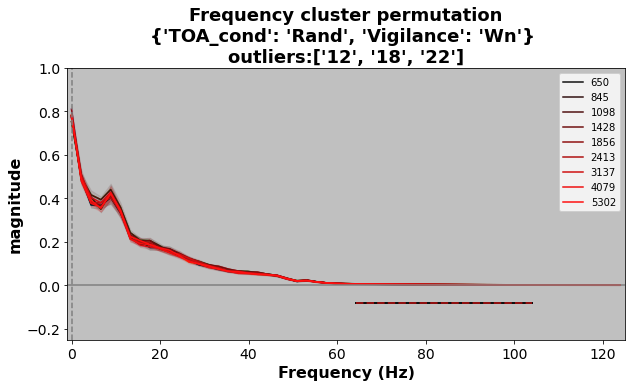

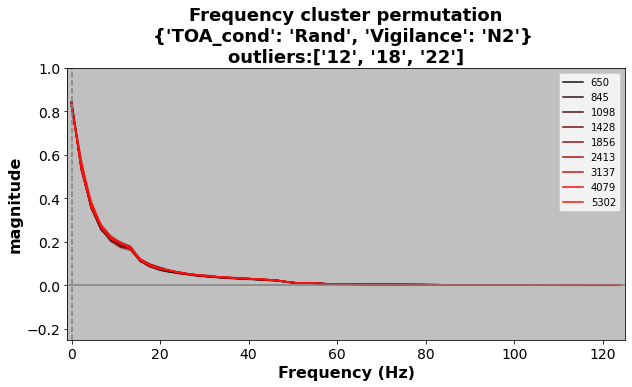

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
contrasts_sep_colors = ['#0f0f0f','#2f0f0f','#4f0f0f','#6f0f0f','#8f0f0f','#af0f0f','#cf0f0f','#ef0f0f','#ff0f0f']
contrastsColors = [[contrasts_sep_colors[0], contrasts_sep_colors[1]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[2]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[3]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[4]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[5]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[6]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[7]],
                   [contrasts_sep_colors[0], contrasts_sep_colors[8]]]
contrastTypeName = 'ToneHeight'
contrasts = [['650','845'],['650','1098'],['650','1428'],['650','1856'],['650','2413'],['650','3137'],['650','4079'],['650','5302']]
contrast_seperateVal = ['650','845','1098','1428','1856','2413','3137','4079','5302']

for TOA_cond in ['T','Rand','Fixed']:
    for vigilance in c['vigi_states']:
        filters= {'TOA_cond':TOA_cond, 'Vigilance':vigilance}
        filters_string = f"{filters}"
        ax = run_cluster_permutation(allEpochs_perCond_freq,ax_y)

        plt.savefig(f'{fig_output_dir}/freqCluster-{TOA_cond}_{vigilance}_allValidSubs_perToneH_5CentElect.png')
        plt.show()

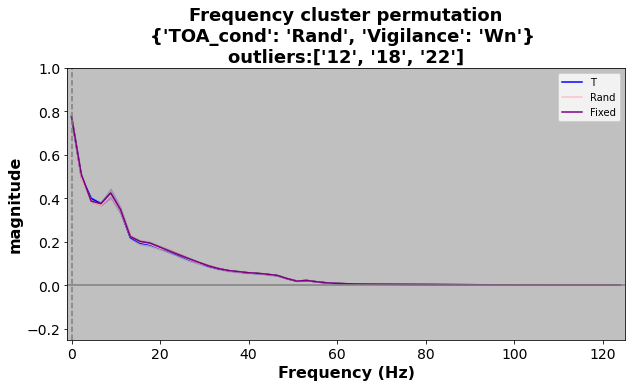

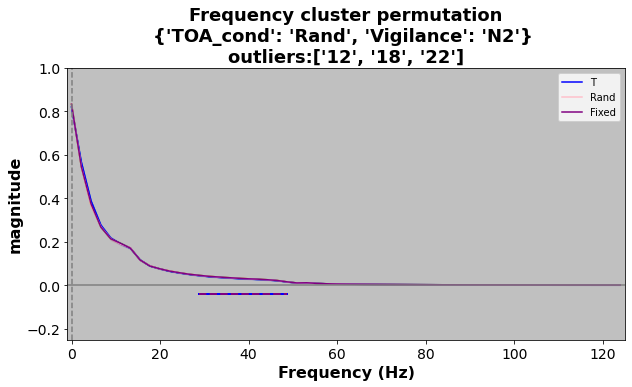

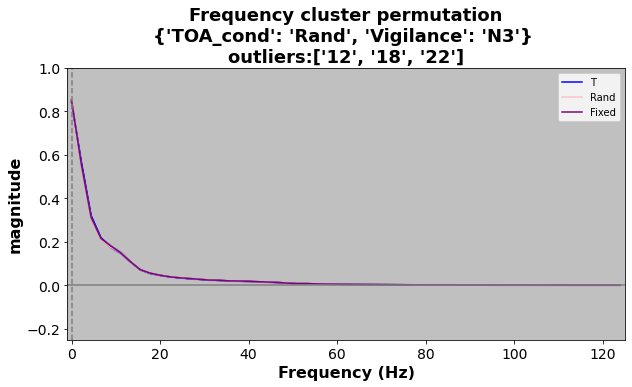

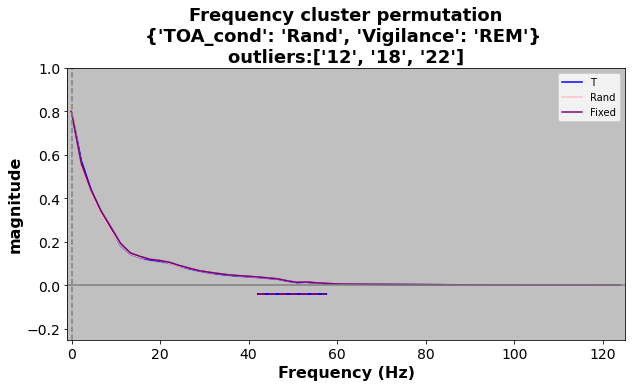

In [ ]:
contrasts = [['T','Rand'],['T','Fixed'],['Rand','Fixed']]
contrastsColors = [ ['blue', 'pink'], ['blue', 'purple'],['purple', 'pink']]
contrastTypeName = 'TOA_cond'
contrast_seperateVal = ['T','Rand','Fixed']
contrasts_sep_colors = ['blue','pink','purple']


for vigilance in c['vigi_states']:
    filters= {'TOA_cond':TOA_cond, 'Vigilance':vigilance}
    filters_string = f"{filters}"
    ax = run_cluster_permutation(allEpochs_perCond_freq,ax_y)

    plt.savefig(f'{fig_output_dir}/freqCluster-{vigilance}_allValidSubs_perTOA_5CentElect.png')
    plt.show()